# Recording A Teleseismic Wavefield From the Nisqually Earthquake

## Name: TYPE YOUR NAME

## Date: PUT THE DATE

This is a small example to introduce you to seismic data.  You will fetch data from IRIS and hopefully will begin to expose yourself to waveform polarization and surface waves.  

In [1]:
# If using Anaconda3 on your machine you can do without this.  This is for Azure people.
!pip install obspy
#!conda install --name root obspy -y
#!conda install obspy -y #May need to run and restart
#!conda update obspy

In [2]:
# Things we'll need in this notebook
from obspy.core import UTCDateTime    # A way of working dates/times in Python - it actually works pretty good
from obspy.clients.fdsn import Client # This will let us read data from IRIS
from obspy.taup import TauPyModel     # This will let us compute global travel times
import matplotlib.pyplot as plt       # An overlay plot
from numpy import linspace
from obspy.geodetics.base import gps2dist_azimuth # Convert (source location, receiver location) to dist/azimuth
from obspy.geodetics import kilometer2degrees     # Convert km to degrees on a sphere; could also use 111.195

# Nisqually Earthquake Details

Here we set the basic event properties corresponding to the event.  Typically, we want to know

1. The origin time or when the event occurred.
2. The event depth (km).
3. The event latitude (degrees).
4. The event longitude (degrees +East).

In [3]:
# Nisqually earthquake details
originTime = UTCDateTime("2001-02-28T18:54:32") #Format is YEAR-MONTH-DAY T HOUR:MINUTE:SECOND
eventDepth     = 57.0   # Event depth (km)
eventLatitude  = 47.19  # Event latitude (degrees)
eventLongitude =-122.66 # Event longitude (degrees +East)
eventMagnitude = 6.8    # Event magnitude (Mw)


# Get The Data the Data at KEV

Here we actually get waveforms from IRIS.  IRIS archives a lot of passive source seismic data and they are located across the street from The University of Washington.  For this example, we will access teleseismic data at station KEV in Helsinki.  

KEV is a Global Seismic Network (GSN) station.  GSN stations are the gold standard of observatory-grade seismic recordings.  To access data we need to know a little about the station.  We identify our stations with a SNCL:

1. _N_etwork Name - GSN stations belong to the IU or II network.
2. _S_tation Name - KEV is the name of the station.
3. _L_ocation Code - This has become the defacto quality metric where 00 is better than 10 is better than 20, etc.
4. _C_hannel Name - This has three letters.  The first letter corresponds to the sample rate and by extension the instrument type.  We typically want B for broadband instruments.  The second letter corresponds to the gain and will typically be H.  And the third letter is the component where
  - Z is up
  - N is north (may also be called 1)
  - E is east (may also be called 2)



In [4]:
client = Client("IRIS")

In [5]:
# Set the SNCL info
network = "IU"
station = "KEV" #"ANMO" or "ADK" also work
channel = "BH?" # The question mark is a `wildcard'.  It means give me ZNE or Z12.  
location = "00"
# If you want to be pedantic you can request each channel one-by-one
#stz = client.get_waveforms("IU", "ANMO", "00", "BHZ", originTime, originTime+1000) #t, t + 60 * 60)
#stn = client.get_waveforms("IU", "ANMO", "00", "BH1", originTime, originTime+1000) #t, t + 60 * 60)
#ste = client.get_waveforms("IU", "ANMO", "00", "BH2", originTime, originTime+1000) #t, t + 60 * 60)
#st = stz + stn + ste
# It's much more convenient to wildcard and get ZNE all at once
stRaw = client.get_waveforms(network, station, location, channel, originTime, originTime+3000) #t, t + 60 * 60)
# Very awkward - but get the station lat/lon (I don't why obspy isn't lifting this from the miniSEED header)
inventory = client.get_stations(network=network, station=station,
                                starttime=originTime, endtime=originTime+400)
for net in inventory:
    for sta in net:
        stationLatitude = sta.latitude
        stationLongitude = sta.longitude

st = stRaw # Memory is cheap so I usually save a copy of the raw data before I process it

# This Is A Seismic Recording

Below is the raw seismic waveform recorded at KEV from the Nisqually earthquake recorded over an hour of time.

# Question - What Do You See?

PUT YOUR ANSWER HERE

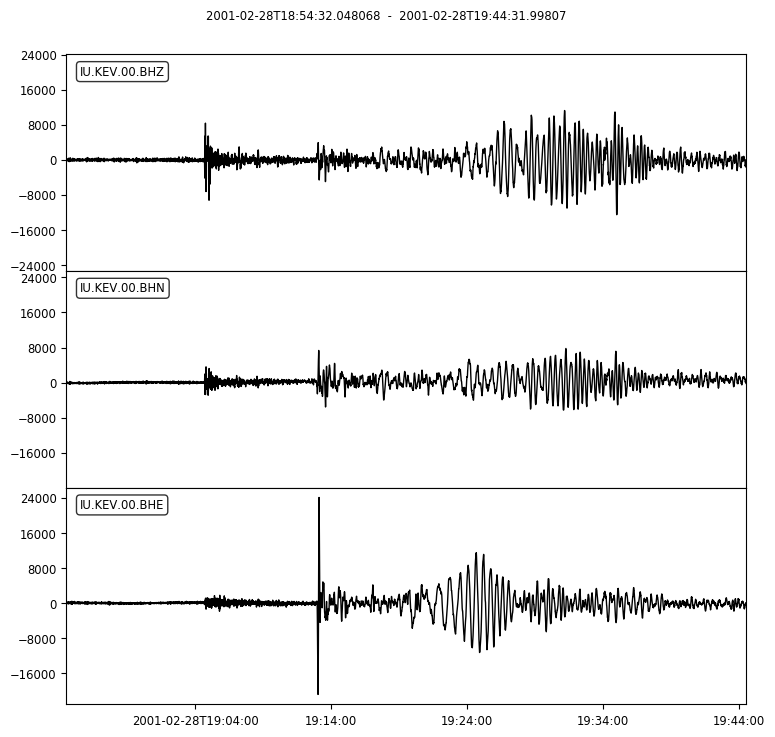

In [5]:
# Demean the data
st = stRaw.detrend()
# Clean the data a little bit to make it easier to see
#st = st.filter("bandpass")#, freqmin=0.1, freqmax=0.8)  
# As a reality check make sure we got our data
st.plot() 

# Zooming In On the Body Waves

Above, the entire wavefield is shown.  That is typically too much.  We can zoom in parts of the wavefield, say the P and S waves.  To do this we need to compute theoretical travel times in a 1D global earth.  Travel time tables in 1D take as input a geodesic distance from the source to the receiver (great circle distance) and earthquake depth.

In [6]:
# This computes travel times for phases in a 1D Earth - we'll see it later i nthe class
model = TauPyModel(model="ak135") 

In [7]:
# Now that I have my data (on st) I want to rotate it to emphasize the transverse and radial components of
# motion.  This amounts to geometry on a sphere.  We now compute the:
# (1) Distance
# (2) Azimuth - the source to receiver angle measured positive from north in degrees.
# (3) Back-azimuth - the receiver to source angle measured positive from north in degrees.
[dist_m, azimuth, backAzimuth] = gps2dist_azimuth(eventLatitude, eventLongitude, stationLatitude, stationLongitude)
# Compute distance in degrees b/c it's more useful
greatCircleDistance = kilometer2degrees(dist_m*1.e-3)
print("The distance from the source to the receiver is %f degrees"%greatCircleDistance)

The distance from the source to the receiver is 61.159395 degrees


In [8]:
# Compute the travel times for the P and S phases
pArrival = model.get_travel_times(source_depth_in_km=eventDepth,
                                  distance_in_degree=greatCircleDistance,
                                  phase_list=["P"]) #, "S"])
sArrival = model.get_travel_times(source_depth_in_km=eventDepth,
                                  distance_in_degree=greatCircleDistance,
                                  phase_list=["S"]) #, "S"])

pArrivalTime = pArrival[0].time
sArrivalTime = sArrival[0].time
pArrivalAOI = pArrival[0].incident_angle
sArrivalAOI = sArrival[0].incident_angle
print("The P waves requires %f seconds to reach the station"%pArrivalTime)
print("The S waves requires %f seconds to reach the station"%sArrivalTime)


The P waves requires 608.512280 seconds to reach the station
The S waves requires 1103.705812 seconds to reach the station


# Question - Which layers of the earth did the P and S waves travel through?

PUT YOUR ANSWER HERE


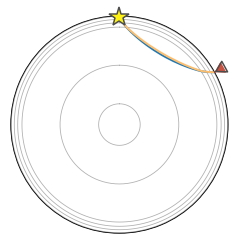

In [9]:
# We can also look at the path the P and S wave traveled through the earth
arrivals = model.get_ray_paths(source_depth_in_km=eventDepth,
                               distance_in_degree=greatCircleDistance,
                               phase_list=["P", "S"])
ax = arrivals.plot_rays()

# Emphasizing Energy Via Rotations

The data are in a natural frame.  But it helps to emphasize certain attributes by rotating into the radial and transverse frame.  A rotation is defined simply by 

$$
 \left \{
  \begin{matrix}
   R \\ T
 \end{matrix}
 \right \}
=\left [
  \begin{matrix}
   -\cos \beta &-\sin \beta \\
    \sin \beta &-\cos \beta
  \end{matrix}
 \right ]
 \left \{
  \begin{matrix}
   N \\ E
 \end{matrix}
 \right \}
$$
where $\beta$ is the back-azimuth.  When we talk about waveform polarization the reason we do this will become clear.

In [10]:
# Rotate the data around the back azimuth.  We always rotate around back-azimuth because the Earth isn't
# perfectly round.  Hence, the azimuth is not 180 - backAzimuth.  The back-azimuth is therefore a better 
# local approximation the angle at which energy is approaching the station.
stRotated = st.rotate(method="NE->RT", back_azimuth=backAzimuth) #, inclination=sArrivalAOI)

# The Primary Arrival at KEV

Below is a plot of the P arrival at KEV on the vertical (up and down), radial, and transverse comopnent.

# Question - On which channel is the P arrival most noticeable?

PUT YOUR ANSWER HERE

# Question - Does any other channel seem to mimic this motion and if yes - which one?

PUT YOUR ANSWER HERE

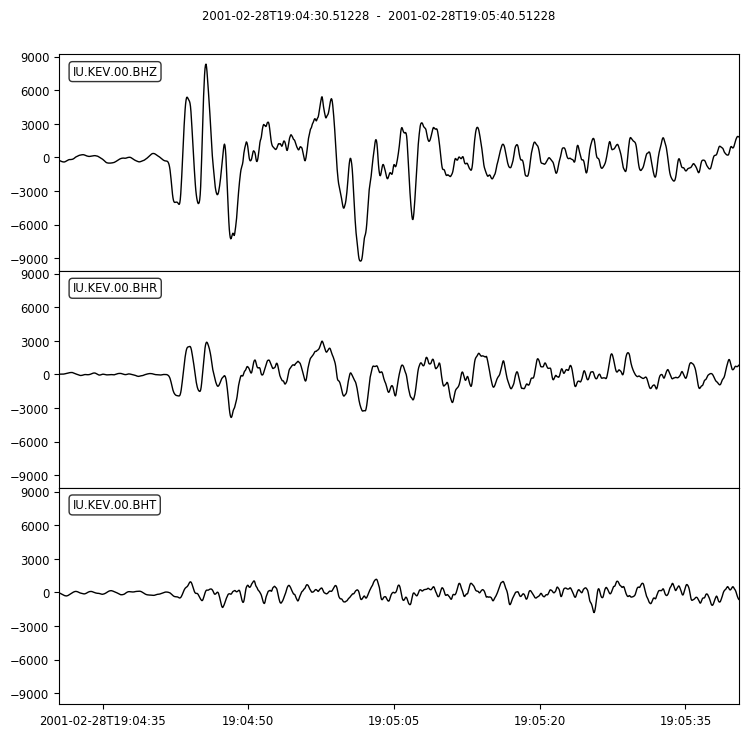

In [11]:
stRotated.plot(starttime=originTime+pArrivalTime-10, endtime=originTime+pArrivalTime+60)

# The Shear Arrival at KEV

Below is a plot of the S arrival at KEV on the vertical, radial, and transverse components.

# Question - Which two channels have the most energy?

PUT YOUR ANSWER HERE

# Question - Do any channels look related - if yes which ones?

PUT YOUR ANSWER HERE

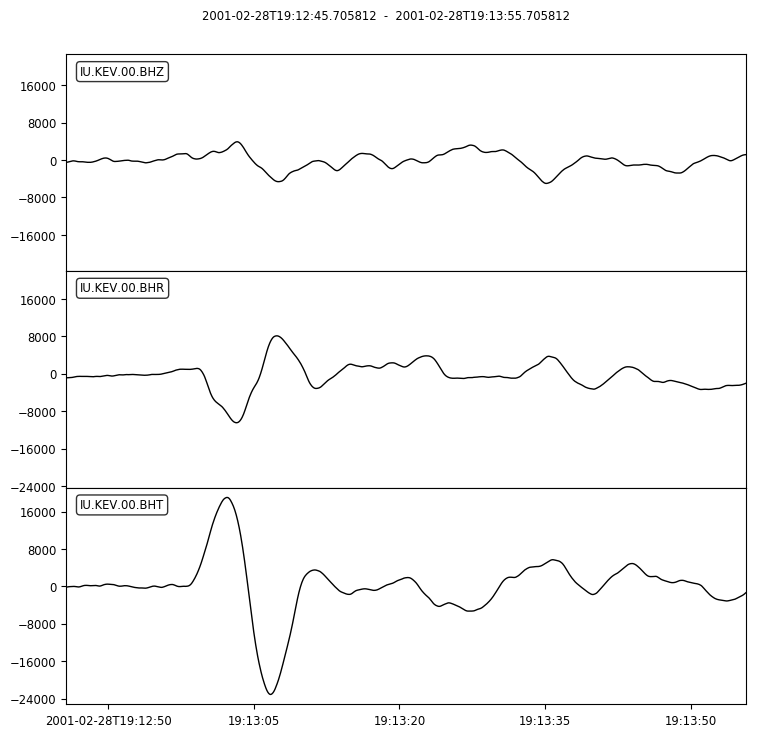

In [22]:
stRotated.plot(starttime=originTime+sArrivalTime-10, endtime=originTime+sArrivalTime+60)

In [23]:
#stRotated[1:3].plot(starttime=originTime+1700, endtime=originTime+2100)
# Cut around this portion of the Rayleigh wave
zCut = stRotated[1].slice(starttime=originTime+1850, endtime=originTime+2100)
rCut = stRotated[2].slice(starttime=originTime+1850, endtime=originTime+2100)
dt = stRotated[1].stats.delta # Get sampling period
times = linspace(1850, 2100, len(zCut.data))


# The Rayleigh Wave

Below is a plot of the some Rayleigh waveform.  

# Question - Is the radial component maximal when the vertical component is 0?

PUT YOUR ANSWER HERE

# Question - Is the vertical component maximal when the radial component is 0?

PUT YOUR ANSWER HERE


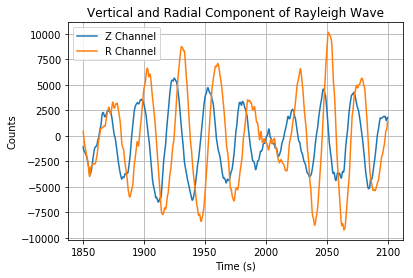

In [24]:
plt.plot(times, zCut, label='Z Channel')
plt.plot(times, rCut, label='R Channel')
plt.grid(True)
plt.legend()
plt.title('Vertical and Radial Component of Rayleigh Wave')
plt.ylabel('Counts')
plt.xlabel('Time (s)')
plt.show()


# The Love Wave - Dispersion

Here a window is taken on the Love wave on the transverse component.  Though it isn't required the signal is lowpass filtered to make the answer to the question a little more obvious.

# Question - Which frequencies in the Love wave arrive earlier - the low or higher frequencies?

PUT YOUR ANSWER HERE

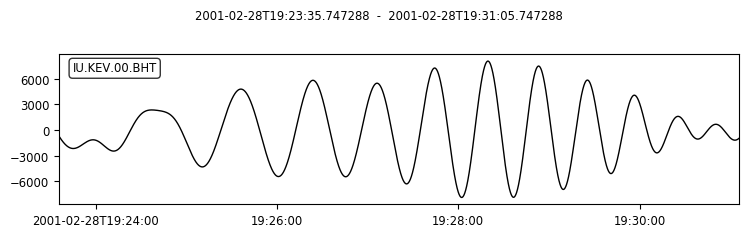

In [82]:
transFiltered = stRotated[0].filter("lowpass", freq=1./20.0)
loveWaveVelocity = 3900.0 # Crude Love wave travel time approximation; probably riding the lower crust in this band
t0 = dist_m/loveWaveVelocity # Crude Love wave travel time approximation
transFiltered.plot(starttime=originTime+t0, endtime=originTime+t0+450) #originTime+800)